<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/test/test_undersmapling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score

#1. Aquisição dos Dados

In [ ]:
data = Path('data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [ ]:
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

#2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [ ]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')

In [ ]:
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


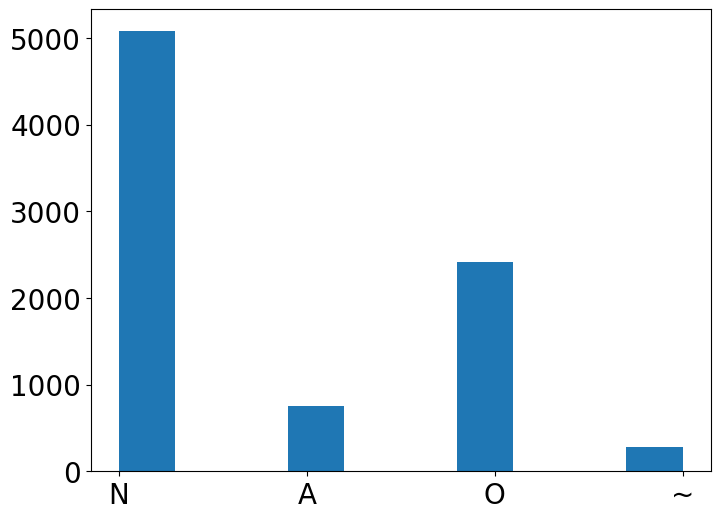

In [ ]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('init_distri.png')
plt.show()

### 2.3 Wavelet helping functions

In [ ]:
def gera_filtro_MH(Escala):
  passo = 1/Escala;
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

In [ ]:
def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

###2.4 Aplicação da tranformada Wavelet

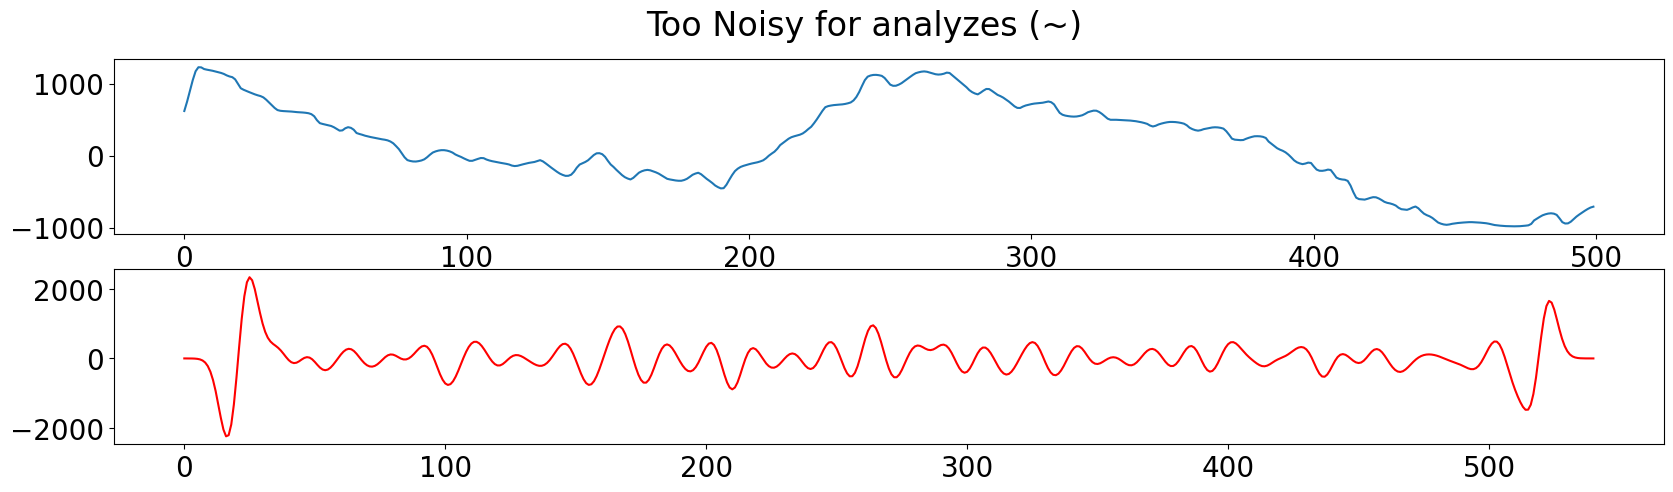

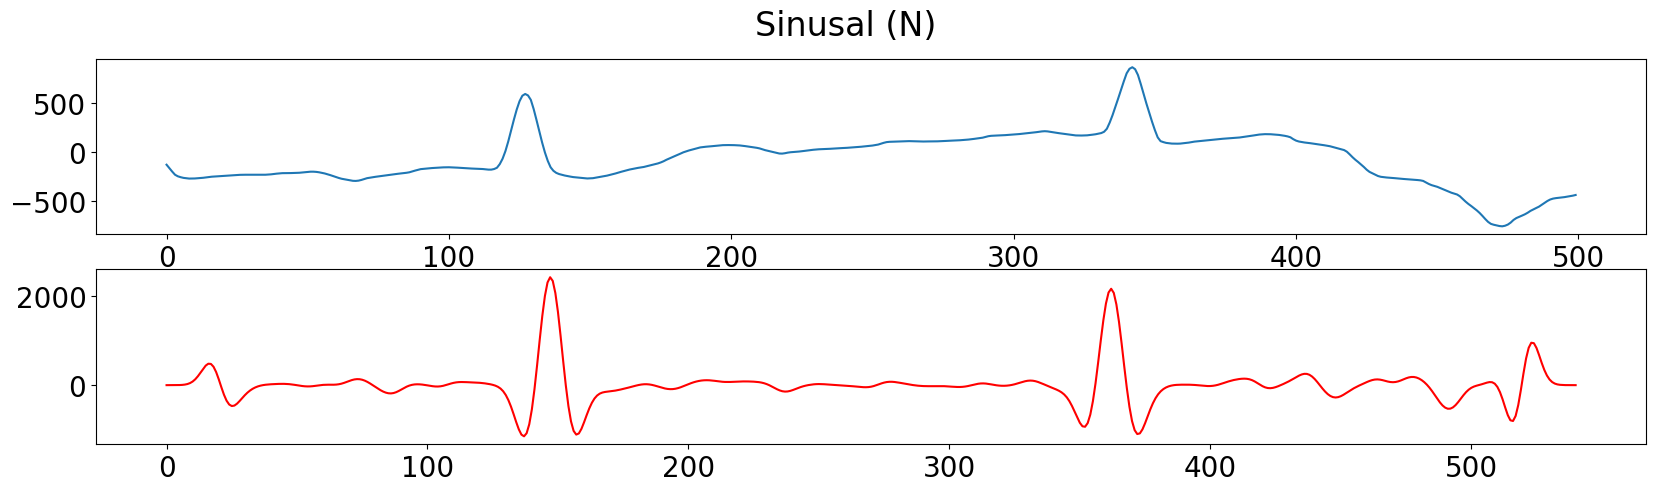

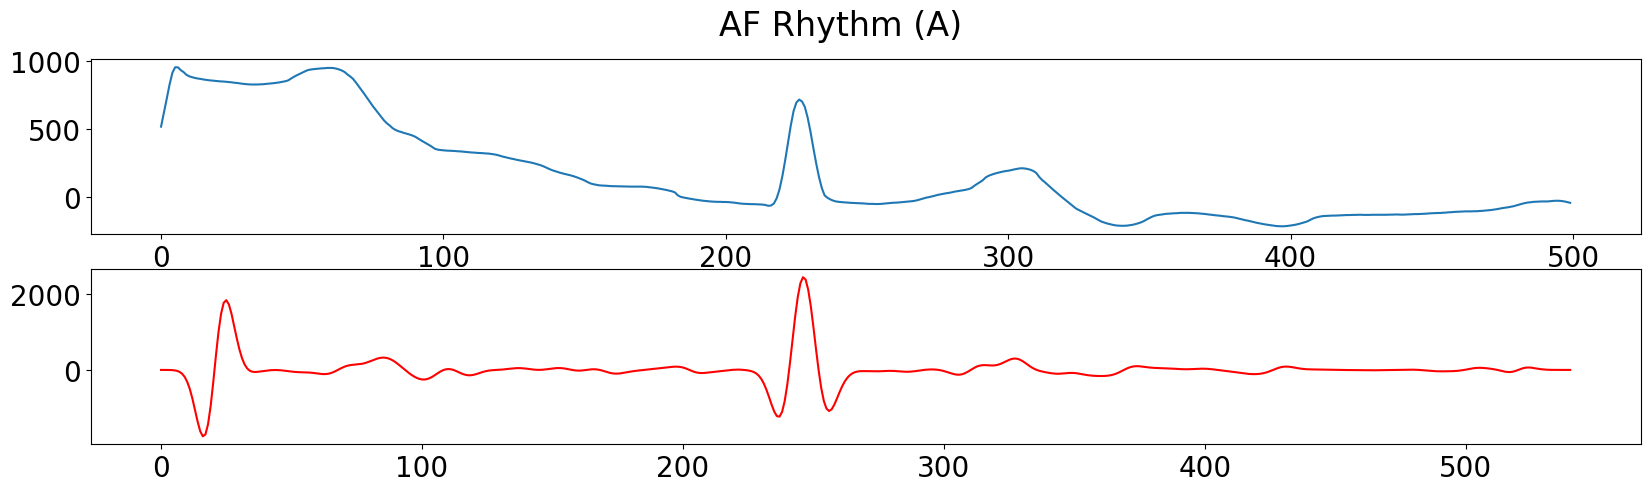

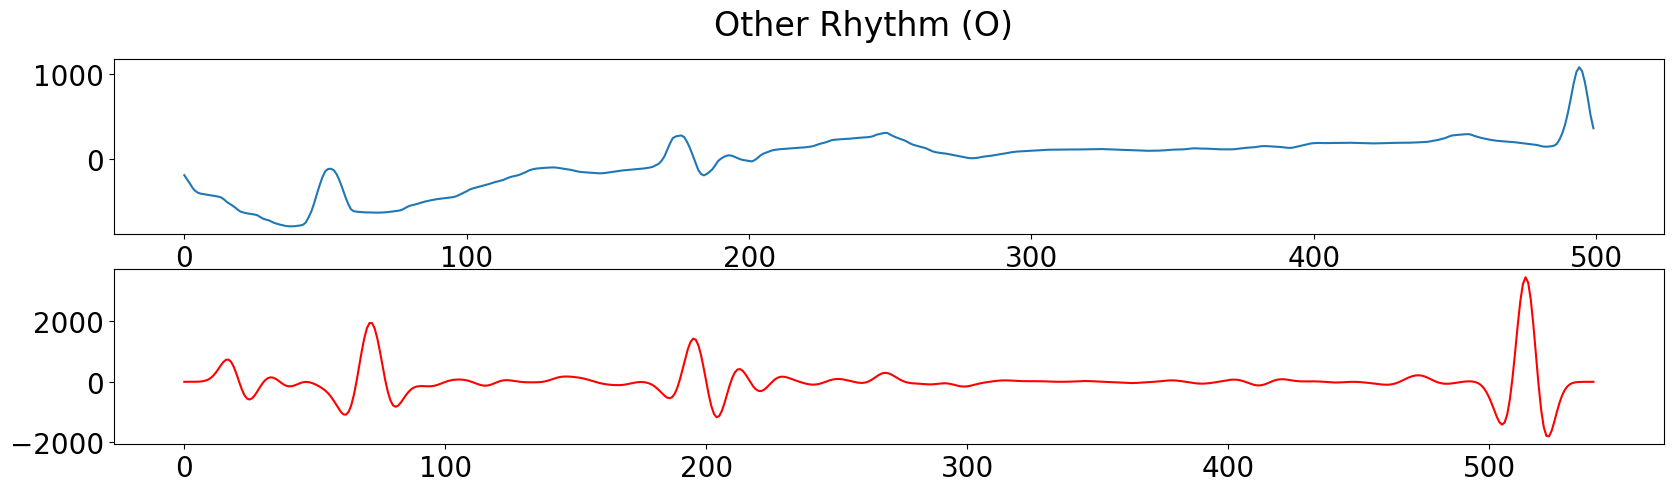

In [ ]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == '~'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Too Noisy for analyzes (~)")
z = apply_wavelet(signal, 2**2)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 2**2)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 2**2)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 2**2)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

In [ ]:
x = []
for i in signals:
  val = apply_wavelet(i, 2**2)
  x.append(val)

### 2.2 Janelamento dos dados de treino

In [ ]:
intersection = 100
window_size = 500
windows_array = ['max','max','max','max']
classes_array = ['N', 'O', 'A', '~']

In [ ]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection)
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [ ]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]

  idx = -1
  for i in classes_array:
    aux = []
    idx += 1
    
    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [ ]:
x_rem, x_test, y_rem, y_test = train_test_split(x, df["classes"], test_size=0.25)

x_rem = np.array(x_rem)
x_rem = x_rem.reshape(-1, 1)
x_rem = list(x_rem)

strategy = {'N':200, 'O':200, 'A':200}
under = RandomUnderSampler(sampling_strategy=strategy)
x_rem, y_rem = under.fit_resample(x_rem, y_rem)
x_rem = [val[0] for val in x_rem]

d_aux = pd.DataFrame({'signals': x_rem, 'classes': y_rem})
d_train = embalance_data(d_aux, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


N
Média: 500.0
Std: 0.0
Qntd: 400
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 400
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 400
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 422
Min: 500
---------------


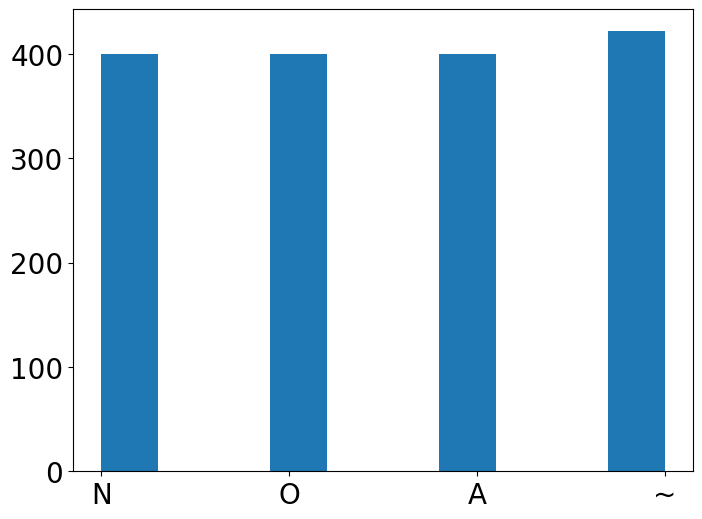

In [ ]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('end_distri.png')
plt.show()

In [ ]:
signals_2 = d_train["signals"]
classes_2 = d_train["classes"]

###2.4 "Normalização" do tamanho dos sinais

In [ ]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]

#3. Implementação da CNN

##3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
y = pd.get_dummies(classes_2)
x_train, x_valid, y_train, y_valid = train_test_split(list(signals_2), y, test_size=0.1)

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
y_valid.shape

(163, 4)

In [ ]:
y_test.shape

(2132,)

In [ ]:
x_train.shape

(1459, 500)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [ ]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
score_acc = make_scorer(accuracy_score)

In [ ]:
len(x_train[0])

500

In [ ]:
input_shape = len(x_train[0])
k1 = 5
k2 = 3
n = math.floor(input_shape/(k1+k2-2))
nn_input = input_shape % (k1+k2-2)

classificador = Sequential()

for i  in range(0, 5):
  if i == 0:
    classificador.add(Conv1D(filters=64, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
  else:
      classificador.add(Conv1D(filters=64, kernel_size = k1, activation = "relu"))
  
  classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
  classificador.add(MaxPooling1D(pool_size=2))

classificador.add(Flatten())

classificador.add(Dense(units=64, activation='relu'))
classificador.add(Dense(units=32, activation='relu'))
classificador.add(Dense(units=64, activation='relu'))

classificador.add(Dense(4, activation="softmax"))

classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])


es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)
print(y_train.shape)
classificador.fit(x_train, y_train, epochs=150, batch_size=128, callbacks=es, verbose=1)



(1459, 4)
Epoch 1/150
12/12 [==============================] - 2s 66ms/step - loss: 1.6194 - accuracy: 0.2570
Epoch 2/150
12/12 [==============================] - 1s 65ms/step - loss: 1.3689 - accuracy: 0.2762
Epoch 3/150
12/12 [==============================] - 1s 65ms/step - loss: 1.3430 - accuracy: 0.3036
Epoch 4/150
12/12 [==============================] - 1s 64ms/step - loss: 1.3191 - accuracy: 0.3509
Epoch 5/150
12/12 [==============================] - 1s 66ms/step - loss: 1.2732 - accuracy: 0.3927
Epoch 6/150
12/12 [==============================] - 1s 63ms/step - loss: 1.2792 - accuracy: 0.4023
Epoch 7/150
12/12 [==============================] - 1s 65ms/step - loss: 1.2195 - accuracy: 0.4407
Epoch 8/150
12/12 [==============================] - 1s 65ms/step - loss: 1.2072 - accuracy: 0.4757
Epoch 9/150
12/12 [==============================] - 1s 65ms/step - loss: 1.1854 - accuracy: 0.4955
Epoch 10/150
12/12 [==============================] - 1s 66ms/step - loss: 1.2292 - accura

In [ ]:
y_pred = classificador.predict(x_valid)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['A', 'N', 'O', '~']

In [ ]:
y_valid = y_valid.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)

In [ ]:
accuracy_score(y_valid, y_pred)
# score = cross_val_score(classificador, x_valid, y_valid, scoring=score_acc, cv=5)

# media = score.mean()
# std = score.std()

0.4601226993865031

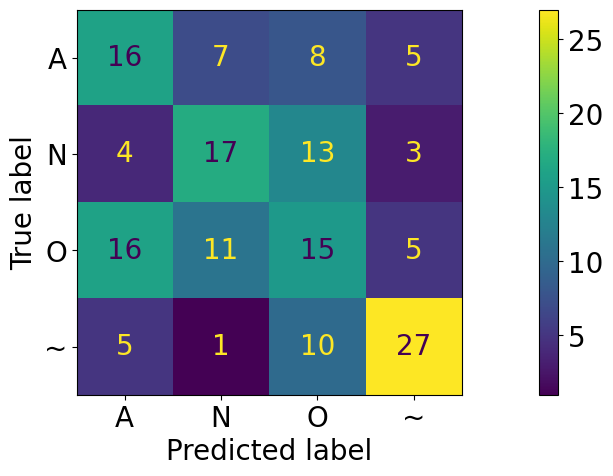

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_valid, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()
plt.savefig("valid.png")

## 4. Verificando  a precisão com os dados de teste

In [ ]:
y_pred = []
for signal in x_test:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)
  
  prediction = classificador.predict(samples)
  prediction = pd.DataFrame(prediction)
  prediction.columns = ['A', 'N', 'O', '~']
  prediction = prediction.idxmax(axis=1)
  val = prediction.mode()[0]
  y_pred.append(val)



In [ ]:
# y_pred = classificador.predict(x_test)
# y_pred = pd.DataFrame(y_pred)
# y_pred.columns = ['A', 'N', 'O', '~']

In [ ]:
# y_test = y_test.idxmax(axis=1)
# # y_pred = y_pred.idxmax(axis=1)

In [ ]:
accuracy_score(y_test, y_pred)
# score = cross_val_score(classificador, x_valid, y_valid, scoring=score_acc, cv=5)

# media = score.mean()
# std = score.std()

0.5623827392120075

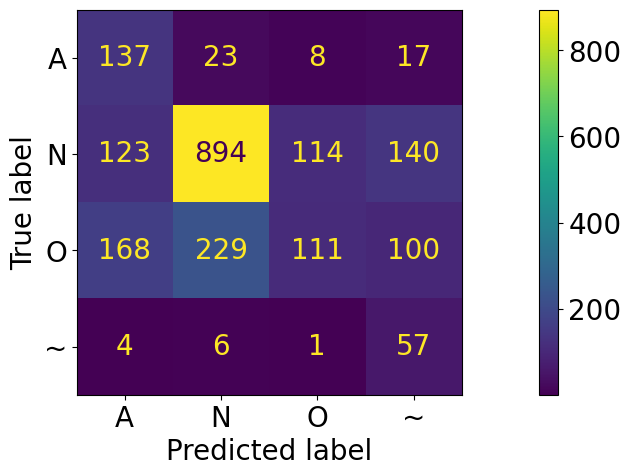

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()
plt.savefig("test.png")

In [ ]:
accuracy_score(y_test, y_pred)

0.5623827392120075